# Capstone Project - Road Accident Severity Prediction

-- **Ayush Mathur**

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Preliminary Wrangling](#wrangling)
* [Data Cleaning](#datacleaning)
* [Analyze](#analyze)
* [Data Preparation and Model building](#modelbuilding)
* [Result and Discussion](#result)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"> </a>

An accident is when a vehicle collides with another vehicle, pedestrian, animal, obstacles, etc. Many factors contribute to collision including road environment, driving skills, speeding, impaired due to drug/alcohol, inattention etc. The total number of persons and vehicles involved, speed, pedestrians and injuries inflicted affect the severity of the accident. Many lives are lost worldwide just in road accidents.

The number of the accidents all around the world is on a continuous rise. A slight delay in the availability of the medical services may be the difference between life and death. This gap can sometimes be a result of the lack of knowledge of the severity of the accident. Having a clear picture of the accident can help authorities provide better emergency services. A model that can predict the severity by weighting in the different factors of weather, road, visibility, light conditions, etc. can be very effective to bridge the gap. Lot of the accidents are also the result of careless driving. How do the environmental factors impact, and their contributions?

Following problem is of the interest of city authorities, department of transportation and people in healthcare. The predictability of the severity of an accident will help emergency staff to prepare well for the injured. It can define variables like how many ambulances, emergency medical staff and police are required on and off site of accident. This can be a crucial information and decrease the time delay and save lives with quick response and adequate resources available. City authorities and department of transportation can plan from patterns of weather and road environments and flag warning to people. The ultimate benefit will be to the local public who would receive better services and there can be probable decline in accidents due to warnings.

## Preliminary Wrangling <a name='wrangling'></a>

We will start with importing all the required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, log_loss, auc, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from collections import Counter

sns.set_style('darkgrid')
%matplotlib inline

**Use the following if imblearn is not install**. imblearn requires atleast sklearn version 0.23.0 to be installed.

!conda install -c conda-forge imbalanced-learn

In [2]:
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN
print(imblearn.__version__)

0.7.0


In [3]:
import sklearn
sklearn.__version__

'0.23.2'

In [4]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42)

Seed everything to ensure code reproducibility.

### Read the Data

In [11]:
df = pd.read_csv('data/Data-Collisions.csv')
df.head()

C:\Users\ayush-pc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


The column names are in uppercase. For ease, we will convert it to lowercase

In [12]:
df.columns = df.columns.str.lower()
df.columns

Index(['severitycode', 'x', 'y', 'objectid', 'inckey', 'coldetkey', 'reportno',
       'status', 'addrtype', 'intkey', 'location', 'exceptrsncode',
       'exceptrsndesc', 'severitycode.1', 'severitydesc', 'collisiontype',
       'personcount', 'pedcount', 'pedcylcount', 'vehcount', 'incdate',
       'incdttm', 'junctiontype', 'sdot_colcode', 'sdot_coldesc',
       'inattentionind', 'underinfl', 'weather', 'roadcond', 'lightcond',
       'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode', 'st_coldesc',
       'seglanekey', 'crosswalkkey', 'hitparkedcar'],
      dtype='object')

Next, We create a copy of the dataframe to work with

In [13]:
df_c = df.copy()
df_c.head()

,severitycode,x,y,objectid,inckey,coldetkey,reportno,status,addrtype,intkey,...,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,seglanekey,crosswalkkey,hitparkedcar
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [14]:
df_c.shape

(194673, 38)

In [15]:
df_c.dtypes

severitycode        int64
x                 float64
y                 float64
objectid            int64
inckey              int64
coldetkey           int64
reportno           object
status             object
addrtype           object
intkey            float64
location           object
exceptrsncode      object
exceptrsndesc      object
severitycode.1      int64
severitydesc       object
collisiontype      object
personcount         int64
pedcount            int64
pedcylcount         int64
vehcount            int64
incdate            object
incdttm            object
junctiontype       object
sdot_colcode        int64
sdot_coldesc       object
inattentionind     object
underinfl          object
weather            object
roadcond           object
lightcond          object
pedrownotgrnt      object
sdotcolnum        float64
speeding           object
st_colcode         object
st_coldesc         object
seglanekey          int64
crosswalkkey        int64
hitparkedcar       object
dtype: objec

We can see there are null values present in the data. let's get a better idea of the same.

In [16]:
df_c.isna().sum()

severitycode           0
x                   5334
y                   5334
objectid               0
inckey                 0
coldetkey              0
reportno               0
status                 0
addrtype            1926
intkey            129603
location            2677
exceptrsncode     109862
exceptrsndesc     189035
severitycode.1         0
severitydesc           0
collisiontype       4904
personcount            0
pedcount               0
pedcylcount            0
vehcount               0
incdate                0
incdttm                0
junctiontype        6329
sdot_colcode           0
sdot_coldesc           0
inattentionind    164868
underinfl           4884
weather             5081
roadcond            5012
lightcond           5170
pedrownotgrnt     190006
sdotcolnum         79737
speeding          185340
st_colcode            18
st_coldesc          4904
seglanekey             0
crosswalkkey           0
hitparkedcar           0
dtype: int64

In [17]:
df_c.isna().sum()/df_c.shape[0]*100

severitycode       0.000000
x                  2.739979
y                  2.739979
objectid           0.000000
inckey             0.000000
coldetkey          0.000000
reportno           0.000000
status             0.000000
addrtype           0.989351
intkey            66.574718
location           1.375126
exceptrsncode     56.434123
exceptrsndesc     97.103861
severitycode.1     0.000000
severitydesc       0.000000
collisiontype      2.519096
personcount        0.000000
pedcount           0.000000
pedcylcount        0.000000
vehcount           0.000000
incdate            0.000000
incdttm            0.000000
junctiontype       3.251093
sdot_colcode       0.000000
sdot_coldesc       0.000000
inattentionind    84.689710
underinfl          2.508822
weather            2.610018
roadcond           2.574574
lightcond          2.655736
pedrownotgrnt     97.602646
sdotcolnum        40.959455
speeding          95.205807
st_colcode         0.009246
st_coldesc         2.519096
seglanekey         0

In [18]:
df_c.isna().any(axis=1).sum()

194673

We have a total of 194673 rows and 38 columns in our dataset. We will next go through all the columns to get an idea about the data and see which columns can be dropped. There are a few unique id columns which will not be an optimum attribute for a model. There are columns with as high as 80 to 97% of null values. Each and every row has atlesat one null value. We will have to impute, drop or work around them. 

In [19]:
df.describe()

,severitycode,x,y,objectid,inckey,coldetkey,intkey,severitycode.1,personcount,pedcount,pedcylcount,vehcount,sdot_colcode,sdotcolnum,seglanekey,crosswalkkey
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,65070.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,1.149360e+05,194673.000000,1.946730e+05
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,37558.450576,1.298901,2.444427,0.037139,0.028391,1.920780,13.867768,7.972521e+06,269.401114,9.782452e+03
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,51745.990273,0.457778,1.345929,0.198150,0.167413,0.631047,6.868755,2.553533e+06,3315.776055,7.226926e+04
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,23807.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007024e+06,0.000000,0.000000e+00
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,28667.000000,1.000000,2.000000,0.000000,0.000000,2.000000,11.000000,6.040015e+06,0.000000,0.000000e+00
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,29973.000000,1.000000,2.000000,0.000000,0.000000,2.000000,13.000000,8.023022e+06,0.000000,0.000000e+00
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,33973.000000,2.000000,3.000000,0.000000,0.000000,2.000000,14.000000,1.015501e+07,0.000000,0.000000e+00
max,2.000000,-122.238949,47.734142,219547.000000,331454.000000,332954.000000,757580.000000,2.000000,81.000000,6.000000,2.000000,12.000000,69.000000,1.307202e+07,525241.000000,5.239700e+06


* More than 50% of the data has 1 as the severitycode. 
* The min no of vehicle count is 0 and 75% of the cases has 2 vehicles involved. Max vehicle count is 12.
* 75% of the cases had no pedestrians involved.Max is 6 pedestrians.
* 75% of the cases had 3 or less persons involved. But the maximum in 81. That is a severe accident. Also an outlier.


In [20]:
df_c['inckey'].nunique(), df_c['coldetkey'].nunique(), df_c['objectid'].nunique()

(194673, 194673, 194673)

Columns 'inckey', 'coldetkey' and 'objectid' are unique keys for the incident. These won't be useful for our model. we will add these columns to the list of attributes to be dropped.

In [21]:
drop_col = ['inckey', 'coldetkey', 'objectid']

In [22]:
df_c['addrtype'].value_counts(dropna=False)

Block           126926
Intersection     65070
NaN               1926
Alley              751
Name: addrtype, dtype: int64

The nan values here will be imputed with the most occuring value.

In [23]:
df_c['intkey'].isna().sum()/df_c.shape[0]

0.6657471760336564

Column 'intkey' is a key that corresponds to the intersection of collision. We will drop this column. It has around 67% of null values

In [24]:
drop_col.append('intkey')

In [25]:
df_c['location'].nunique()

24102

In [26]:
df_c['location'].head(20)

0                            5TH AVE NE AND NE 103RD ST
1            AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N
2           4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST
3              2ND AVE BETWEEN MARION ST AND MADISON ST
4                       SWIFT AVE S AND SWIFT AV OFF RP
5                            24TH AVE NW AND NW 85TH ST
6                            DENNY WAY AND WESTLAKE AVE
7                                BROADWAY AND E PIKE ST
8                   PINE ST BETWEEN 5TH AVE AND 6TH AVE
9                         41ST AVE SW AND SW THISTLE ST
10                                                  NaN
11               1ST AV S BR NB AND EAST MARGINAL WAY S
12    SW SPOKANE ST BETWEEN SW SPOKANE W BR AND TERM...
13             TERRY AVE BETWEEN JAMES ST AND CHERRY ST
14    ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...
15           9TH AVE BETWEEN LENORA ST AND BLANCHARD ST
16                           AURORA AVE N AND N 87TH ST
17    BATTERY ST TUN ON RP BETWEEN BELL ST AND A

Column 'location' will be dropped.

In [27]:
drop_col.append('location')

In [28]:
df_c[['severitycode', 'intkey', 'inckey', 'coldetkey', 'objectid', 'exceptrsncode', 'sdot_colcode', 'seglanekey']].corr()

,severitycode,intkey,inckey,coldetkey,objectid,sdot_colcode,seglanekey
severitycode,1.000000,0.006553,0.022065,0.022079,0.020131,0.188905,0.104276
intkey,0.006553,1.000000,0.048524,0.048499,0.046929,0.007114,-0.010510
inckey,0.022065,0.048524,1.000000,0.999996,0.946383,-0.027617,0.019701
coldetkey,0.022079,0.048499,0.999996,1.000000,0.945837,-0.027461,0.019586
objectid,0.020131,0.046929,0.946383,0.945837,1.000000,-0.037094,0.028076
sdot_colcode,0.188905,0.007114,-0.027617,-0.027461,-0.037094,1.000000,0.206835
seglanekey,0.104276,-0.010510,0.019701,0.019586,0.028076,0.206835,1.000000


In [29]:
print(df_c['exceptrsncode'].unique())
df_c['exceptrsncode'].value_counts(dropna=False)

[' ' nan 'NEI']


NaN    109862
        79173
NEI      5638
Name: exceptrsncode, dtype: int64

In [30]:
print(df_c['exceptrsndesc'].unique())
df_c['exceptrsndesc'].value_counts(dropna=False)

[nan 'Not Enough Information, or Insufficient Location Information']


NaN                                                             189035
Not Enough Information, or Insufficient Location Information      5638
Name: exceptrsndesc, dtype: int64

In [31]:
df_c[df_c['exceptrsncode'] == 'NEI']['exceptrsndesc']

74        Not Enough Information, or Insufficient Locati...
103       Not Enough Information, or Insufficient Locati...
106       Not Enough Information, or Insufficient Locati...
116       Not Enough Information, or Insufficient Locati...
171       Not Enough Information, or Insufficient Locati...
                                ...                        
194600    Not Enough Information, or Insufficient Locati...
194621    Not Enough Information, or Insufficient Locati...
194623    Not Enough Information, or Insufficient Locati...
194657    Not Enough Information, or Insufficient Locati...
194659    Not Enough Information, or Insufficient Locati...
Name: exceptrsndesc, Length: 5638, dtype: object

Column 'exceptrsndesc' is the description column for the value in column 'exceptrsncode'. The only values present in both columns is nan or Not Enough Information. Hence the following 2 columns cannot be used in our analysis.

In [32]:
drop_col.extend(['exceptrsncode', 'exceptrsndesc'])

we will be dropping 'sdotcolnum', 'st_coldesc', 'st_colcode', 'sdot_colcode', 'seglanekey', 'crosswalkkey'. These are columns that contains the key and description for the collision by state, keys for lane and crosswalk.

* st_colcode

In [33]:
drop_col.extend(['sdotcolnum', 'st_coldesc', 'st_colcode', 'sdot_colcode', 'seglanekey', 'crosswalkkey'])

In [34]:
df_c['severitycode.1'].nunique(), df_c['severitydesc'].nunique(), df_c['severitycode'].nunique()

(2, 2, 2)

In [35]:
df_c['severitycode'].value_counts(dropna=False)

1    136485
2     58188
Name: severitycode, dtype: int64

In [36]:
df_c['severitycode.1'].value_counts(dropna=False)

1    136485
2     58188
Name: severitycode.1, dtype: int64

In [37]:
df_c['severitydesc'].value_counts(dropna=False)

Property Damage Only Collision    136485
Injury Collision                   58188
Name: severitydesc, dtype: int64

In [38]:
(df_c['severitycode.1'] == df_c['severitycode']).all()

True

In [39]:
df_c[df_c['severitycode'] == 1]['severitydesc'].value_counts(dropna=False)

Property Damage Only Collision    136485
Name: severitydesc, dtype: int64

In [40]:
df_c[df_c['severitycode'] == 2]['severitydesc'].value_counts(dropna=False)

Injury Collision    58188
Name: severitydesc, dtype: int64

From the above cells is clear that the 3 columns 'severitycode', 'severitycode.1' and 'severitydesc' are identical in information. 'severitydesc' is the description for the other 2 columns which are identical. Column 'severitycode' will be our target column for analysis to predict the severity of the accident. We will drop the columns with redundant information.

In [41]:
drop_col.extend(['severitycode.1', 'severitydesc'])

In [42]:
df_c['collisiontype'].value_counts(dropna=False)

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
NaN            4904
Right Turn     2956
Head On        2024
Name: collisiontype, dtype: int64

Nan values in column can either be dropped or converted 'Unknown' or 'Other'. In this case, we will convert the nan to value 'Other'

In [43]:
df_c['personcount'].nunique(), df_c['personcount'].isna().sum()

(47, 0)

column 'personcount' is the number of people involved in the accident and we don't have any null values. This will be an important column in our analysis.

In [44]:
df_c['pedcount'].value_counts(dropna=False)

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: pedcount, dtype: int64

In [45]:
df_c['pedcylcount'].value_counts(dropna=False)

0    189189
1      5441
2        43
Name: pedcylcount, dtype: int64

In [46]:
df_c['vehcount'].value_counts(dropna=False)

2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: vehcount, dtype: int64

Most of the cases in the dataset are where no pedestrians were involved but we have quite a few pedestrians involved cases.

In [47]:
np.nan in df_c['incdate'].unique()

False

In [48]:
np.nan in df_c['incdttm'].unique()

False

In [49]:
df_c[['incdate', 'incdttm']].head(10)

,incdate,incdttm
0,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM
1,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM
2,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM
3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM
4,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM
5,2019/04/20 00:00:00+00,4/20/2019 5:42:00 PM
6,2008/12/09 00:00:00+00,12/9/2008
7,2020/04/15 00:00:00+00,4/15/2020 5:47:00 PM
8,2006/06/15 00:00:00+00,6/15/2006 1:00:00 PM
9,2006/03/20 00:00:00+00,3/20/2006 3:49:00 PM


Columns 'incdate' and 'incdttm' are accident date and accident datetime respectively. We will drop the 'incdate' column and convert column 'incdttm' to datetime. And retrieve month, day and hour

In [50]:
drop_col.append('incdate')

In [51]:
df_c['junctiontype'].isna().sum(), df_c['junctiontype'].nunique()

(6329, 7)

In [52]:
df_c['junctiontype'].value_counts(dropna=False)

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
NaN                                                   6329
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: junctiontype, dtype: int64

The nan values in junctiontype can be converted to value 'Unknown'.

In [53]:
df_c['sdot_colcode'].isna().sum(), df_c['sdot_colcode'].nunique()

(0, 39)

In [54]:
df_c['sdot_coldesc'].isna().sum(), df_c['sdot_coldesc'].nunique()

(0, 39)

In [55]:
df_c['sdot_colcode'].value_counts().values == df_c['sdot_coldesc'].value_counts().values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

We will drop the column 'sdot_coldesc'

In [56]:
drop_col.append('sdot_coldesc')

In [57]:
print(df_c['inattentionind'].isna().sum())
df_c['inattentionind'].value_counts(dropna=False)

164868


NaN    164868
Y       29805
Name: inattentionind, dtype: int64

The column 'inattentionind' only has "Y" and nan values. We can infer from this that only the "Y" value was documented and the cases where the value was "N" was left blank. In this case, we can replace the Nan value with a "N". Here "Y" refers to Yes and "N" refers to "No". The column provides us with the information if the driver was not paying attention while driving. Here, we will replace the values nan and Y with 0 and 1 respectively.

In [58]:
df_c['underinfl'].value_counts(dropna=False)

N      100274
0       80394
Y        5126
NaN      4884
1        3995
Name: underinfl, dtype: int64

In [59]:
df_c['underinfl'].isna().sum()/df_c.shape[0]*100

2.5088224869396374

Column 'underinfl' provides us if the driver was under influence of any drug or alcohol. We have multiple values with the same meaning in different formats. This is similar to the above case. We will convert the values N and Y to 0,1 respetively. In this case, we cannot infer about the value of the Nan cases. These are unknown and can either be 0 or 1. We can impute the value with the category of highest frequency i.e. 0. But nan constitute about 2.5% of the total data and we will drop the null values

In [60]:
df_c['weather'].value_counts(dropna=False)

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
NaN                           5081
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: weather, dtype: int64

In the column 'weather', Converting the nan values to 'Unknown' is a better option than converting to 'Other' or dropping.

In [61]:
df_c['roadcond'].value_counts(dropna=False)

Dry               124510
Wet                47474
Unknown            15078
NaN                 5012
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: roadcond, dtype: int64

Just as in the above case, we will replace the nan values in column 'roadcond' to 'Unknown'.

In [62]:
df_c['lightcond'].value_counts(dropna=False)

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
NaN                           5170
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: lightcond, dtype: int64

We can convert the nan values in 'lightcond' to value 'Unknown'

In [63]:
df_c['pedrownotgrnt'].value_counts(dropna=False)

NaN    190006
Y        4667
Name: pedrownotgrnt, dtype: int64

In the case of column 'pedrownotgrnt', We can infer that only the vale "Y" (Yes) was documented and the No values were left out. We will convert the nan values to 0 and "Y" to 1. The column provides us with the information if the pedestrian right of way was not granted.

In [64]:
df_c['speeding'].value_counts(dropna=False)

NaN    185340
Y        9333
Name: speeding, dtype: int64

In column 'speeding', we infer that the values are yes and no. Therefore, we will convert the nan to 0 and "Y" to 1. The column provides us with the information if the driver was speeding his car.

In [65]:
df_c['hitparkedcar'].value_counts(dropna=False)

N    187457
Y      7216
Name: hitparkedcar, dtype: int64

Column 'hitparkedcar' provides us with the info if the car hit a parked car. Column has 'N' and 'Y' values. we will convert the values 'N' and 'Y' to 0 and 1 respectively.

In [66]:
df_c['reportno'].nunique()

194670

Column 'reportno' has a unique value for each accident. This is not a useful attribute for our analysis. we will drop this column.

In [67]:
drop_col.append('reportno')

In [68]:
df['status'].value_counts(dropna=False)

Matched      189786
Unmatched      4887
Name: status, dtype: int64

The values in column 'status' are imbalanced and after dropping other nan values only 1 unmatched value is left. We will drop this column.

In [69]:
drop_col.append('status')

In [70]:
df_c[['x', 'y']].head(10)

,x,y
0,-122.323148,47.703140
1,-122.347294,47.647172
2,-122.334540,47.607871
3,-122.334803,47.604803
4,-122.306426,47.545739
5,-122.387598,47.690575
6,-122.338485,47.618534
7,-122.320780,47.614076
8,-122.335930,47.611904
9,-122.384700,47.528475


Column 'x' and 'y' are co-ordinates. we will drop these fir now.

In [71]:
drop_col.extend(['x', 'y'])

In [72]:
drop_col

['inckey',
 'coldetkey',
 'objectid',
 'intkey',
 'location',
 'exceptrsncode',
 'exceptrsndesc',
 'sdotcolnum',
 'st_coldesc',
 'st_colcode',
 'sdot_colcode',
 'seglanekey',
 'crosswalkkey',
 'severitycode.1',
 'severitydesc',
 'incdate',
 'sdot_coldesc',
 'reportno',
 'status',
 'x',
 'y']

In [73]:
df.dtypes

severitycode        int64
x                 float64
y                 float64
objectid            int64
inckey              int64
coldetkey           int64
reportno           object
status             object
addrtype           object
intkey            float64
location           object
exceptrsncode      object
exceptrsndesc      object
severitycode.1      int64
severitydesc       object
collisiontype      object
personcount         int64
pedcount            int64
pedcylcount         int64
vehcount            int64
incdate            object
incdttm            object
junctiontype       object
sdot_colcode        int64
sdot_coldesc       object
inattentionind     object
underinfl          object
weather            object
roadcond           object
lightcond          object
pedrownotgrnt      object
sdotcolnum        float64
speeding           object
st_colcode         object
st_coldesc         object
seglanekey          int64
crosswalkkey        int64
hitparkedcar       object
dtype: objec

* Columns to be dropped.
* Convert nan to value 'other' in column 'collisiontype'.
* Convert the nan values in junctiontype to the value 'Unknown'.
* Replace values Nan and Y in column 'inattentionind' with 0 and 1 respectively.
* Replace N and Y values in 'underinfl' with 0 and 1. Drop the null values.
* Change the dtype of column 'underinfl' from object to int.
* Convert nan values in 'weather' to 'Unknown'.
* Replace the nan values in 'roadcond' to 'Unknown'.
* Replace the nan, "Y" values to 0 and 1 respectively in column 'pedrownotgrnt'.
* Replace the nan and "Y" values in column 'speeding' to 0 and 1.
* Drop null values from column 'addrtype'
* One-hot encode columns 'collisiontype', 'junctiontype', 'weather', 'roadcond', 'lightcond' and drop columns 'Other' or 'Unknown' from each.
* Convert the data-type of 'incdttm' to datetime and extract month, day and hour of the day.

## Data Cleaning <a name="datacleaning"></a>

#### Define

* Columns to be dropped

#### Code

In [74]:
df_c.drop(drop_col, axis=1, inplace=True)

#### Verify

In [75]:
df_c.shape

(194673, 17)

In [76]:
df_c.columns

Index(['severitycode', 'addrtype', 'collisiontype', 'personcount', 'pedcount',
       'pedcylcount', 'vehcount', 'incdttm', 'junctiontype', 'inattentionind',
       'underinfl', 'weather', 'roadcond', 'lightcond', 'pedrownotgrnt',
       'speeding', 'hitparkedcar'],
      dtype='object')

#### Define

* Convert nan to value 'other' in column 'collisiontype'.
* Convert the nan values in junctiontype to the value 'Unknown'.
* Replace values Nan and Y in column 'inattentionind' with 0 and 1 respectively.


#### Code

In [77]:
df_c['collisiontype'].replace(np.nan, 'Other', inplace=True)
df_c['junctiontype'].replace(np.nan, 'Unknown', inplace=True)
df_c['inattentionind'].replace([np.nan, 'Y'], [0,1], inplace=True)

#### Verify

In [78]:
df_c['collisiontype'].value_counts(dropna=True, normalize=True)

Parked Car    0.246501
Angles        0.178114
Rear Ended    0.175114
Other         0.146949
Sideswipe     0.095591
Left Turn     0.070390
Pedestrian    0.033944
Cycles        0.027816
Right Turn    0.015184
Head On       0.010397
Name: collisiontype, dtype: float64

In [79]:
df_c['junctiontype'].value_counts(dropna=True, normalize=True)

Mid-Block (not related to intersection)              0.461286
At Intersection (intersection related)               0.322644
Mid-Block (but intersection related)                 0.117068
Driveway Junction                                    0.054815
Unknown                                              0.032557
At Intersection (but not related to intersection)    0.010777
Ramp Junction                                        0.000853
Name: junctiontype, dtype: float64

In [80]:
df_c['inattentionind'].value_counts(dropna=False, normalize=True)

0    0.846897
1    0.153103
Name: inattentionind, dtype: float64

#### Define
* Replace N and Y values in 'underinfl' with 0 and 1. Drop the null values.
* Change the dtype of column 'underinfl' from object to int.
* Replace 'N', 'Y' values in column 'hitparkedcar' to 0 and 1 respectively.

### Code

In [81]:
df_c['underinfl'].replace(['N', 'Y'], [0,1], inplace=True)
df_c.dropna(axis=0, subset=['underinfl'], inplace=True)
df_c['underinfl'] = df_c['underinfl'].astype('int')
df_c['hitparkedcar'].replace(['N', 'Y'], [0,1], inplace=True)

#### Verify

In [82]:
df_c['underinfl'].value_counts(dropna=False, normalize=True)

0    0.951941
1    0.048059
Name: underinfl, dtype: float64

In [83]:
df_c['hitparkedcar'].value_counts(dropna=False, normalize=True)

0    0.963549
1    0.036451
Name: hitparkedcar, dtype: float64

#### Define
* Replace nan values in 'weather' to 'Unknown'.
* Convert values with very low proportion in 'weather' to 'Other'.
* Replace the nan values in 'roadcond' to 'Unknown'.
* Convert values with very low proportion in 'roadcond' to 'Other'.
* Replace nan value in column 'lightcond' to 'Unknown'. 
* Create a column 'streetlight' despicting cases where streetlight was on.
* Merge all values containing 'dark' in column 'lightcond'.

#### Code

In [84]:
# Column 'weather'
df_c['weather'].replace(np.nan, 'Unknown', inplace=True)
rep_val = [val for val in df['weather'].unique() if val not in ['Overcast', 'Raining', 'Clear', 'Unknown']]
df_c['weather'].replace(rep_val, 'Other', inplace=True)

# Column 'roadcond'
df_c['roadcond'].replace(np.nan, 'Unknown', inplace=True)
rep_val = [val for val in df['roadcond'].unique() if val not in ['Wet', 'Dry', 'Unknown']]
df_c['roadcond'].replace(rep_val, 'Other', inplace=True)

# Column 'lightcond'
df_c['lightcond'].replace(np.nan, 'Unknown', inplace=True)
df_c['streetlight'] = (df_c['lightcond'] == 'Dark - Street Lights On').astype('int')
replace_light = ['Dark - Street Lights On', 'Dark - No Street Lights', 'Dark - Street Lights Off', 'Dark - Unknown Lighting']
df_c['lightcond'].replace(replace_light, ['Dark']*4, inplace=True)

#### Verify

In [85]:
df_c['weather'].value_counts(dropna=False, normalize=True)

Clear       0.585571
Raining     0.174641
Overcast    0.146025
Unknown     0.080553
Other       0.013209
Name: weather, dtype: float64

In [86]:
df_c['roadcond'].value_counts(dropna=False, normalize=True)

Dry        0.656044
Wet        0.250141
Unknown    0.080121
Other      0.013694
Name: roadcond, dtype: float64

In [87]:
df_c['lightcond'].value_counts(dropna=False, normalize=True)

Daylight    0.611927
Dark        0.270058
Unknown     0.072496
Dusk        0.031098
Dawn        0.013183
Other       0.001238
Name: lightcond, dtype: float64

In [88]:
df_c['streetlight'].value_counts(normalize=True)

0    0.744416
1    0.255584
Name: streetlight, dtype: float64

#### Define
* Replace the nan, "Y" values to 0 and 1 respectively in column 'pedrownotgrnt'.
* Replace the nan and "Y" values in column 'speeding' to 0 and 1.

#### Code

In [89]:
df_c['pedrownotgrnt'].replace([np.nan, 'Y'], [0,1], inplace=True)
df_c['speeding'].replace([np.nan, 'Y'], [0,1], inplace=True)

#### Verify

In [90]:
df_c['pedrownotgrnt'].value_counts(dropna=False)

0    185122
1      4667
Name: pedrownotgrnt, dtype: int64

In [91]:
df_c['speeding'].value_counts(dropna=False)

0    180456
1      9333
Name: speeding, dtype: int64

#### Define
* Drop null values from column 'addrtype' 

#### Code

In [92]:
df_c.dropna(subset=['addrtype'], inplace=True)

#### Verify

In [93]:
df_c['addrtype'].value_counts(dropna=False, normalize=True)

Block           0.657892
Intersection    0.338134
Alley           0.003974
Name: addrtype, dtype: float64

#### Define

* Convert the data-type of 'incdttm' to datetime and extract month, day of month and hour of the day.

#### Code

In [94]:
df_c['incdttm'] = pd.to_datetime(df_c['incdttm'], infer_datetime_format=True)
df_c['month'] = df_c['incdttm'].dt.strftime("%b")
df_c['day'] = df_c['incdttm'].dt.strftime("%d")
df_c['hour'] = df_c['incdttm'].dt.strftime("%H")

#### Verify

In [95]:
df_c[['incdttm', 'month', 'day', 'hour']].head()

,incdttm,month,day,hour
0,2013-03-27 14:54:00,Mar,27,14
1,2006-12-20 18:55:00,Dec,20,18
2,2004-11-18 10:20:00,Nov,18,10
3,2013-03-29 09:26:00,Mar,29,09
4,2004-01-28 08:04:00,Jan,28,08


In [96]:
df_c[['incdttm', 'month', 'day', 'hour']].dtypes

incdttm    datetime64[ns]
month              object
day                object
hour               object
dtype: object

In [97]:
df_c.shape

(187970, 21)

In [98]:
df_c.dtypes

severitycode               int64
addrtype                  object
collisiontype             object
personcount                int64
pedcount                   int64
pedcylcount                int64
vehcount                   int64
incdttm           datetime64[ns]
junctiontype              object
inattentionind             int64
underinfl                  int32
weather                   object
roadcond                  object
lightcond                 object
pedrownotgrnt              int64
speeding                   int64
hitparkedcar               int64
streetlight                int32
month                     object
day                       object
hour                      object
dtype: object

**Save cleaned dataset for later analysis. Further we will one-hot encode categorical data using pd.get_dummies.**

In [99]:
df_c.to_csv('data/df_cleaned.csv', index=False)

* One-hot encode columns 'collisiontype', 'junctiontype', 'weather', 'roadcond', 'lightcond' and drop columns containing 'Unknown' from each.

In [100]:
dum_col = ['collisiontype', 'junctiontype', 'weather', 'roadcond', 'lightcond', 'addrtype']
dum_drop=['junctiontype_Unknown', 'weather_Unknown', 'roadcond_Unknown', 'lightcond_Unknown','addrtype_Alley']
dum_drop.extend(['junctiontype_At Intersection (but not related to intersection)','junctiontype_Ramp Junction'])
df_c = pd.get_dummies(df_c, columns=dum_col).drop(dum_drop, axis=1)
print(df_c.shape)
df_c.head()

(187970, 43)


,severitycode,personcount,pedcount,pedcylcount,vehcount,incdttm,inattentionind,underinfl,pedrownotgrnt,speeding,...,roadcond_Dry,roadcond_Other,roadcond_Wet,lightcond_Dark,lightcond_Dawn,lightcond_Daylight,lightcond_Dusk,lightcond_Other,addrtype_Block,addrtype_Intersection
0,2,2,0,0,2,2013-03-27 14:54:00,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,1,2,0,0,2,2006-12-20 18:55:00,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2,1,4,0,0,3,2004-11-18 10:20:00,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3,1,3,0,0,3,2013-03-29 09:26:00,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
4,2,2,0,0,2,2004-01-28 08:04:00,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


**Save the final data. This will be used to bulid models.**

In [101]:
df_c.to_csv('data/final_df.csv', index=False)

### Analyze <a name='analyze'></a>

**Load the cleaned dataset. The final data will be used later for model building.**

In [102]:
df_cleaned = pd.read_csv('data/df_cleaned.csv')
df_cleaned['incdttm'] = pd.to_datetime(df_cleaned['incdttm'], infer_datetime_format=True)
df_cleaned['day'] = df_cleaned['day'].astype(object)
df_cleaned['hour'] = df_cleaned['hour'].astype(object)
df_cleaned.head()

,severitycode,addrtype,collisiontype,personcount,pedcount,pedcylcount,vehcount,incdttm,junctiontype,inattentionind,...,weather,roadcond,lightcond,pedrownotgrnt,speeding,hitparkedcar,streetlight,month,day,hour
0,2,Intersection,Angles,2,0,0,2,2013-03-27 14:54:00,At Intersection (intersection related),0,...,Overcast,Wet,Daylight,0,0,0,0,Mar,27,14
1,1,Block,Sideswipe,2,0,0,2,2006-12-20 18:55:00,Mid-Block (not related to intersection),0,...,Raining,Wet,Dark,0,0,0,1,Dec,20,18
2,1,Block,Parked Car,4,0,0,3,2004-11-18 10:20:00,Mid-Block (not related to intersection),0,...,Overcast,Dry,Daylight,0,0,0,0,Nov,18,10
3,1,Block,Other,3,0,0,3,2013-03-29 09:26:00,Mid-Block (not related to intersection),0,...,Clear,Dry,Daylight,0,0,0,0,Mar,29,9
4,2,Intersection,Angles,2,0,0,2,2004-01-28 08:04:00,At Intersection (intersection related),0,...,Raining,Wet,Daylight,0,0,0,0,Jan,28,8


In [103]:
df_cleaned.dtypes

severitycode               int64
addrtype                  object
collisiontype             object
personcount                int64
pedcount                   int64
pedcylcount                int64
vehcount                   int64
incdttm           datetime64[ns]
junctiontype              object
inattentionind             int64
underinfl                  int64
weather                   object
roadcond                  object
lightcond                 object
pedrownotgrnt              int64
speeding                   int64
hitparkedcar               int64
streetlight                int64
month                     object
day                       object
hour                      object
dtype: object

In [104]:
df_cleaned.describe()

,severitycode,personcount,pedcount,pedcylcount,vehcount,inattentionind,underinfl,pedrownotgrnt,speeding,hitparkedcar,streetlight
count,187970.000000,187970.000000,187970.000000,187970.000000,187970.000000,187970.000000,187970.000000,187970.000000,187970.000000,187970.000000,187970.000000
mean,1.303181,2.462893,0.038437,0.029382,1.970245,0.157850,0.048364,0.024812,0.049364,0.035745,0.256961
std,0.459634,1.359460,0.201465,0.170225,0.559684,0.364601,0.214535,0.155554,0.216628,0.185654,0.436959
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.000000,81.000000,6.000000,2.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [105]:
df_cleaned['severitycode'].value_counts(normalize=True)

1    0.696819
2    0.303181
Name: severitycode, dtype: float64

We have a slightly imbalanced data. There are 70% cases for severity-code 1 and 30% cases are severity-code 2.

**There are a few ways to deal with this.**
- Use stratified train-test split: 
- Accuracy will not be a very good metric. We will use F1 score for evaluation.
- Decision trees work better with imbalanced data.
- If required, we can use resampling. 

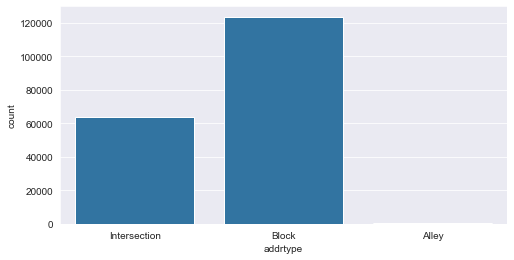

In [106]:
base_color = sns.color_palette()[0]
plt.figure(figsize=(8,4))
sns.countplot(data=df_cleaned, x='addrtype', color=base_color);

Most accidents have occured at Block followed by 'Intersection'. Alley has the least accidents about 0.3% only. 

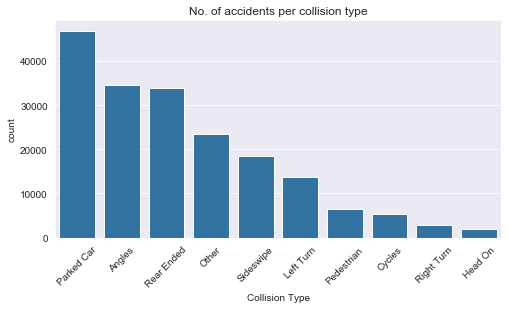

In [107]:
base_color = sns.color_palette()[0]
order = df_cleaned['collisiontype'].value_counts().index
plt.figure(figsize=(8,4))
sns.countplot(data=df_cleaned, x='collisiontype', order=order, color=base_color)
plt.xticks(rotation=45)
plt.xlabel('Collision Type')
plt.title('No. of accidents per collision type');

Most accidents involved a parked car. Suggests driver mistake followed by angles and 'rear ended'.

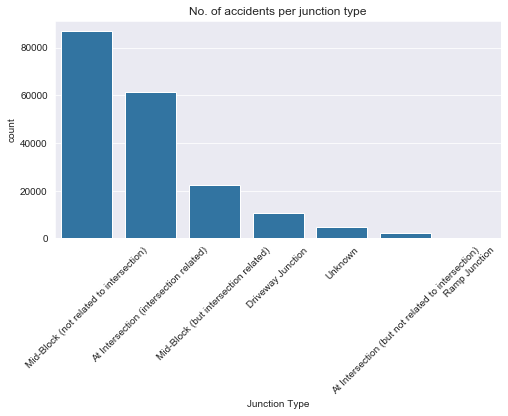

In [108]:
base_color = sns.color_palette()[0]
order = df_cleaned['junctiontype'].value_counts().index
plt.figure(figsize=(8,4))
sns.countplot(data=df_cleaned, x='junctiontype', order=order, color=base_color)
plt.xticks(rotation=45)
plt.xlabel('Junction Type')
plt.title('No. of accidents per junction type');

In [109]:
df_cleaned['junctiontype'].value_counts(normalize=True)

Mid-Block (not related to intersection)              0.462191
At Intersection (intersection related)               0.326196
Mid-Block (but intersection related)                 0.119035
Driveway Junction                                    0.056057
Unknown                                              0.024722
At Intersection (but not related to intersection)    0.010949
Ramp Junction                                        0.000851
Name: junctiontype, dtype: float64

The last 3 options -'Unknown', 'At Intersection (but not related to intersection') and Ramp Junction are not good predictors with only 3.7% of total cases collectively. We have dropped these columns when one-hot encoding the attribute.

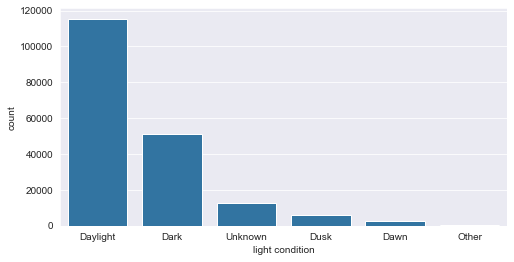

In [110]:
base_color = sns.color_palette()[0]
order = df_cleaned['lightcond'].value_counts().index
plt.figure(figsize=(8,4))
sns.countplot(data=df_cleaned, x='lightcond', order=order, color=base_color)
#plt.xticks(rotation=45)
plt.xlabel('light condition');

In [111]:
df_cleaned['lightcond'].value_counts(normalize=True)

Daylight    0.614290
Dark        0.271485
Unknown     0.068612
Dusk        0.031154
Dawn        0.013252
Other       0.001208
Name: lightcond, dtype: float64

<Figure size 720x1008 with 0 Axes>

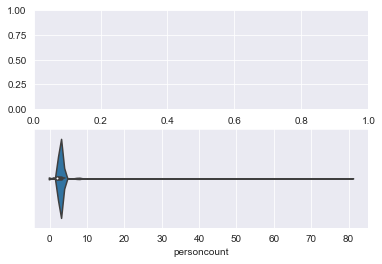

In [112]:
plt.figure(figsize=(10,14))
plt.subplots(2,1)

sns.violinplot(data=df_cleaned, x='personcount');

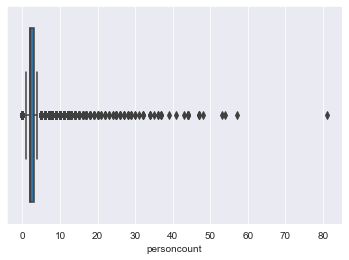

In [113]:
sns.boxplot(data=df_cleaned, x='personcount');

In most cases, the number of persons involved in an accident is less than 5 but we have increasing count with many outliers. It is obvious to have less accidents with many persons involved.

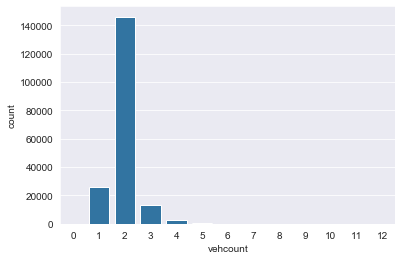

In [114]:
base_color = sns.color_palette()[0]
sns.countplot(data=df_cleaned, x='vehcount', color=base_color);

Most cases had 2 vehicles involved followed by 1 and 3 vehicles.

In [115]:
df_cleaned.columns

Index(['severitycode', 'addrtype', 'collisiontype', 'personcount', 'pedcount',
       'pedcylcount', 'vehcount', 'incdttm', 'junctiontype', 'inattentionind',
       'underinfl', 'weather', 'roadcond', 'lightcond', 'pedrownotgrnt',
       'speeding', 'hitparkedcar', 'streetlight', 'month', 'day', 'hour'],
      dtype='object')

In [116]:
df_cleaned.dtypes

severitycode               int64
addrtype                  object
collisiontype             object
personcount                int64
pedcount                   int64
pedcylcount                int64
vehcount                   int64
incdttm           datetime64[ns]
junctiontype              object
inattentionind             int64
underinfl                  int64
weather                   object
roadcond                  object
lightcond                 object
pedrownotgrnt              int64
speeding                   int64
hitparkedcar               int64
streetlight                int64
month                     object
day                       object
hour                      object
dtype: object

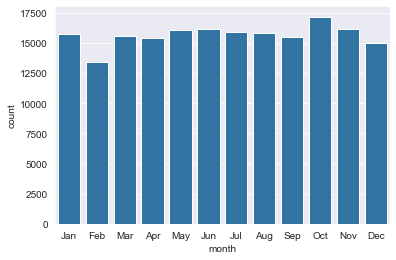

In [117]:
base_color=sns.color_palette()[0]
order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.countplot(data=df_c, x='month', order=order, color=base_color);

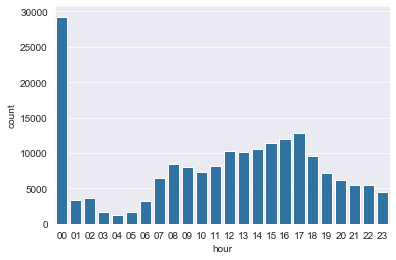

In [118]:
sns.countplot(data=df_c,x='hour',color=base_color);

In [119]:
df_c[df_c['hour'] == '00']['incdttm']

6        2008-12-09 00:00:00
16       2005-07-01 00:00:00
19       2009-06-01 00:00:00
30       2005-11-05 00:00:00
40       2006-08-05 00:00:00
                 ...        
194414   2019-01-04 00:24:00
194418   2019-01-24 00:08:00
194482   2019-01-11 00:44:00
194502   2018-11-21 00:00:00
194653   2018-12-10 00:47:00
Name: incdttm, Length: 29245, dtype: datetime64[ns]

The hour '00' i.e. midnight has way too many cases than any other time of the day. It is because many of these values contain only the date information and the default time "00:00:00" is added. 

## Data preparation and model building <a name='modelbuilding'></a>

In [5]:
X = pd.read_csv('data/final_df.csv')

In [6]:
y = X['severitycode']
X = X.drop(['severitycode', 'month', 'hour', 'incdttm'], axis=1)

In [7]:
X.shape

(187970, 39)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)
print("Train data shape: ", X_train.shape, ", ", y_train.shape )
print("Test data shape: ", X_test.shape, ", ", y_test.shape)

Train data shape:  (131579, 39) ,  (131579,)
Test data shape:  (56391, 39) ,  (56391,)


We have used stratify to ensure that both target classes are represented in the test set. Now, we will standardize both the train and test set using the StandardScaler.

In [9]:
std_scale = StandardScaler()
X_train = std_scale.fit_transform(X_train)
X_test = std_scale.transform(X_test)

In [11]:
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for i in range(5):
    lr = LogisticRegression(solver=solver[i], random_state=42).fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)
    print(solver[i])
    print("f1-score : ", f1_score(y_test, y_pred))
    print('log-loss: ', log_loss(y_test, y_proba))
    print('recall   : ', recall_score(y_test, y_pred))
    print("precision score: ", precision_score(y_test, y_pred))
    print('accuracy : ', lr.score(X_train, y_train))
    print()

newton-cg
f1-score :  0.8444774808257594
log-loss:  0.4808644698972203
recall   :  0.9541151320812338
precision score:  0.7574398448390811
accuracy :  0.7550596979761208

lbfgs
f1-score :  0.8444904946391567
log-loss:  0.4808651077647747
recall   :  0.9541405812592253
precision score:  0.757444745242232
accuracy :  0.7550520979791608

liblinear
f1-score :  0.8444774808257594
log-loss:  0.4808645075288112
recall   :  0.9541151320812338
precision score:  0.7574398448390811
accuracy :  0.7550596979761208

sag
f1-score :  0.8444774808257594
log-loss:  0.48086451002946384
recall   :  0.9541151320812338
precision score:  0.7574398448390811
accuracy :  0.7550596979761208

saga
f1-score :  0.8444774808257594
log-loss:  0.4808645409982934
recall   :  0.9541151320812338
precision score:  0.7574398448390811
accuracy :  0.7550596979761208



In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.95      0.84     39294
           2       0.74      0.30      0.42     17097

    accuracy                           0.76     56391
   macro avg       0.75      0.63      0.63     56391
weighted avg       0.75      0.76      0.72     56391



Our data is imbalanced with the class proportions of 0.7 and 0.3. Therefore, if we just predict the majority value for every test case, we will have an accuracy of 70%. Above logistic regression has an accuracy of 75%, i.e. it performs slightly better than a random guess. Hence, we cannot use accuracy score as a valid measure of evaluation for our models.

Precision is the proportion of actual True positives in total number of positives predicted. Whereas, recall score is the ratio of number of True positives predicted by the actual positives in the dataset. f1 score is the balance of the two scores(precision and recall).  

In the above cases, We have good accuracy, high f1-score and recall. We will be using 'f1_macro' score and macro recall for evluation. It is a balance/average of the f1 score for both the classes in the data. The above models are good at predicting the valve 1 of severity-code. Whereas the prediction of the value 2 is low. Lets check if we can bring up the f1 score for the value 2.

In [10]:
lr_cv = LogisticRegressionCV(Cs = 30,cv=5, random_state=42, scoring='f1_macro')
lr_cv.fit(X_train, y_train)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.4808646853975979
              precision    recall  f1-score   support

           1       0.76      0.95      0.84     39294
           2       0.74      0.30      0.42     17097

    accuracy                           0.76     56391
   macro avg       0.75      0.63      0.63     56391
weighted avg       0.75      0.76      0.72     56391



In [23]:
y_pred_train = lr_cv.predict(X_train)
y_proba_train = lr_cv.predict_proba(X_train)
print("log-loss: ", log_loss(y_train, y_proba_train))
print(classification_report(y_train, y_pred_train))

log-loss:  0.48254842912561846
              precision    recall  f1-score   support

           1       0.76      0.95      0.84     91687
           2       0.74      0.30      0.42     39892

    accuracy                           0.76    131579
   macro avg       0.75      0.63      0.63    131579
weighted avg       0.75      0.76      0.72    131579



Using the LogisticRegressionCV, We have received similar results on both the test and training data set. Logistic regression has a parameter "balanced" which accounts for the imbalance in the dataset by assigning weights to each class based on their proportion in the data. 

Next, check the results using "class_Weight = 'balanced'".

In [24]:
lr_cv_b = LogisticRegressionCV(Cs=30, cv=5, class_weight='balanced', random_state=42, scoring='f1_macro')
lr_cv_b.fit(X_train, y_train)


y_pred = lr_cv_b.predict(X_test)
y_proba = lr_cv_b.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.544594199987606
              precision    recall  f1-score   support

           1       0.87      0.63      0.73     39294
           2       0.48      0.79      0.60     17097

    accuracy                           0.68     56391
   macro avg       0.68      0.71      0.66     56391
weighted avg       0.75      0.68      0.69     56391



The logisticRegressionCV model with parameter class_weight = 'balanced' performs better at predicting the value 2 in severity-code. The precision, recall and f1-score for value 2 are far better. The macro recall and macro f1 scores are better than the previous model. We have a dip in f1-score and recall of value 1 but there is significant increase in the precision. 

Value 2 represents a more severe accident than value 1. So the cost of predicting value 2 is more than value 1.  Overall, the above model is better than our base model of LogisticRegression.

In [32]:
lr_cv = LogisticRegressionCV(Cs=30, cv=10, solver='liblinear', random_state=42, scoring='f1_macro')
lr_cv.fit(X_train, y_train)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.4808635111063204
              precision    recall  f1-score   support

           1       0.76      0.95      0.84     39294
           2       0.74      0.30      0.42     17097

    accuracy                           0.76     56391
   macro avg       0.75      0.63      0.63     56391
weighted avg       0.75      0.76      0.72     56391



In [33]:
confusion_matrix(y_test, y_pred)

array([[37491,  1803],
       [12006,  5091]], dtype=int64)

The above model is similar to our base model. A change in the solver paramter made no difference in the results.
From the above confusion matrix, many value 2 are incorrectly classified as value 1 -(12006 cases) and 1803 value 1 cases are incorrect.

In [34]:
lr_cv = LogisticRegressionCV(Cs=30, cv=10, solver='liblinear', class_weight='balanced', random_state=42, scoring='f1_macro')
lr_cv.fit(X_train, y_train)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.5584309062145303
              precision    recall  f1-score   support

           1       0.87      0.62      0.72     39294
           2       0.48      0.80      0.60     17097

    accuracy                           0.67     56391
   macro avg       0.67      0.71      0.66     56391
weighted avg       0.75      0.67      0.69     56391



In [35]:
confusion_matrix(y_test, y_pred)

array([[24283, 15011],
       [ 3489, 13608]], dtype=int64)

In above model- from the confusion matrix, only 3489 value 2 cases are incorrectly classified as value 1 but 15011 value 1 cases are incorrect.

Predicting a value 1 case as a value 2 has low cost inferred. As interpreting a slightly low severity as a high case will make people to take precautions. But predicting value 2 as value 1 can cause the lack of providing services to the ones involved in the accident. Thereby, It has more cost attached to it.

* ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

In [36]:
dtc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_proba = dtc.predict_proba(X_test)
print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  24.067636662641952
              precision    recall  f1-score   support

           1       0.76      0.86      0.81     39294
           2       0.55      0.38      0.45     17097

    accuracy                           0.72     56391
   macro avg       0.65      0.62      0.63     56391
weighted avg       0.70      0.72      0.70     56391



In [ ]:
confusion_matrix(y_test, y_pred)

The decision tree classifier is comparable to our base model with slight improvement. But the logistic regression with class weight is the best one yet.

In [127]:
rfc = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print("Train Data Score: ", rfc.score(X_train, y_train))
print("OOB Score: ", rfc.oob_score_)
print('logg-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

Train Data Score:  0.8573708570516572
OOB Score:  0.7231397107441156
logg-loss:  0.859092790307961
              precision    recall  f1-score   support

           1       0.77      0.86      0.81     39294
           2       0.56      0.41      0.48     17097

    accuracy                           0.72     56391
   macro avg       0.67      0.64      0.64     56391
weighted avg       0.71      0.72      0.71     56391



In [128]:
confusion_matrix(y_test, y_pred)

array([[33746,  5548],
       [10039,  7058]], dtype=int64)

Random forest classifier with default parameters is comparable to decision tree model with only a slight imporvement. The recall, f1-score and precision are low for value 2. Slight tweeking in parameters can be checked for a better model.

In [76]:
pipe =Pipeline([('classifier', RandomForestClassifier())])

# Create parameter grid

param = [
    {'classifier':[LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 3, 20)},
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(10, 101, 10)),
     'classifier__max_features' : list(range(6, 32, 5))
    }]

clf = GridSearchCV(pipe, param_grid=param, cv=5, scoring=['f1', 'auc'], verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 78.9min finished


In [77]:
results = pd.DataFrame.from_dict(best_clf.cv_results_)

In [78]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__max_features,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,65.458393,32.576192,0.000000,0.000000,"LogisticRegression(C=0.0379269019073225, class...",0.0001,l1,NaN,NaN,{'classifier': LogisticRegression(C=0.03792690...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
1,5.468904,2.186643,0.027381,0.009475,"LogisticRegression(C=0.0379269019073225, class...",0.0001,l2,NaN,NaN,{'classifier': LogisticRegression(C=0.03792690...,0.750228,0.750988,0.750798,0.751178,0.750523,0.750743,0.000336,20
2,0.423537,0.079053,0.000000,0.000000,"LogisticRegression(C=0.0379269019073225, class...",0.000233572,l1,NaN,NaN,{'classifier': LogisticRegression(C=0.03792690...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84
3,2.241810,0.402245,0.021389,0.005534,"LogisticRegression(C=0.0379269019073225, class...",0.000233572,l2,NaN,NaN,{'classifier': LogisticRegression(C=0.03792690...,0.750798,0.754142,0.751216,0.753078,0.752461,0.752339,0.001220,19
4,0.354780,0.030904,0.000000,0.000000,"LogisticRegression(C=0.0379269019073225, class...",0.000545559,l1,NaN,NaN,{'classifier': LogisticRegression(C=0.03792690...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,89.658286,1.610170,1.035160,0.036901,"RandomForestClassifier(bootstrap=True, ccp_alp...",NaN,NaN,31,60,{'classifier': RandomForestClassifier(bootstra...,0.742894,0.746618,0.745706,0.746808,0.741972,0.744800,0.001989,48
96,104.076090,0.379707,1.208453,0.042519,"RandomForestClassifier(bootstrap=True, ccp_alp...",NaN,NaN,31,70,{'classifier': RandomForestClassifier(bootstra...,0.742780,0.745934,0.743502,0.747074,0.741288,0.744116,0.002108,70
97,120.132337,1.136959,1.393937,0.045509,"RandomForestClassifier(bootstrap=True, ccp_alp...",NaN,NaN,31,80,{'classifier': RandomForestClassifier(bootstra...,0.743122,0.744680,0.744186,0.748480,0.742580,0.744610,0.002073,61
98,137.079236,1.309541,1.601807,0.029818,"RandomForestClassifier(bootstrap=True, ccp_alp...",NaN,NaN,31,90,{'classifier': RandomForestClassifier(bootstra...,0.743388,0.745098,0.745554,0.747454,0.741820,0.744663,0.001922,58


In [81]:
best_clf.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 LogisticRegression(C=0.0379269019073225, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [84]:
best_clf.best_score_

0.7546568895318873

In [86]:
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)
print("f1-score: ", f1_score(y_test, y_pred))
print('logg-loss: ', log_loss(y_test, y_proba))

f1-score:  0.8442662642597327
logg-loss:  0.48101841864732653


Above test was a random comparison to test the best of the two models with a grid of a couple of parameter checks for each model. Logiction Regression was the better of the two.

In [129]:
models = []
models.append(('LogR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTreeC', DecisionTreeClassifier()))
models.append(('RForrestC', RandomForestClassifier()))

In [130]:
def resamp_model_test(X_n, y_n, mod=''):
    results = []
    names=[]
    print("Using resampled data from ", mod)
    for name, model in models:
        cv_results = cross_val_score(model, X_n, y_n, cv=5, scoring='f1_macro')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return 1    

In [131]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X_train, y_train)
print("Original Dataset target counts", Counter(y_train))
print("Resampled Dataset target counts: ", Counter(y_res))

Original Dataset target counts Counter({1: 91687, 2: 39892})
Resampled Dataset target counts:  Counter({1: 91687, 2: 91687})


In [ ]:
resamp_model_test(X_res, y_res, 'Random Over-sampler')

Using resampled data from  Random Over-sampler
LogR: 0.702889 (0.001507)
KNN: 0.705313 (0.010511)
DTreeC: 0.754978 (0.014551)
RForrestC: 0.763160 (0.012277)


We have the best results from RandomForrestClassifier. With imbalanced data a RandomForrestClassifier should outperform Logistic Regression.

In [19]:
rfc = RandomForestClassifier(oob_score=True, random_state=42)
rfc.fit(X_res, y_res)
print("Score on training data: ", rfc.score(X_res, y_res))
print("OOB Score: ", rfc.oob_score_)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

Score on training data:  0.8446071962219289
OOB Score:  0.7683313883102294
log-loss:  1.0900263799150571
              precision    recall  f1-score   support

           1       0.81      0.69      0.75     39294
           2       0.47      0.63      0.54     17097

    accuracy                           0.67     56391
   macro avg       0.64      0.66      0.64     56391
weighted avg       0.71      0.67      0.69     56391



In [20]:
confusion_matrix(y_test, y_pred)

array([[27261, 12033],
       [ 6296, 10801]], dtype=int64)

After the random over sampling the RandomForestClassifier perform better then when used by the actual data. When comparing the previous random forest model, We have an increase in precision, recall and f1-score for value 2 with increase in macro presion and macro recall. We also have an increase for precision in value 1 predictions with a little dip in recall and f1 score. Comparing to the base logistic model, above outperforms it and with logistic balanced model, both are comparable with the logistic model slightly better.

Let's compare random forest with logistic regression model for the resampled data.

In [132]:
lr_cv = LogisticRegressionCV(Cs = 30,cv=5, random_state=42, scoring='f1_macro')
lr_cv.fit(X_res, y_res)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.54292764165228
              precision    recall  f1-score   support

           1       0.87      0.62      0.73     39294
           2       0.48      0.79      0.60     17097

    accuracy                           0.67     56391
   macro avg       0.68      0.71      0.66     56391
weighted avg       0.75      0.67      0.69     56391



In [133]:
confusion_matrix(y_test, y_pred)

array([[24540, 14754],
       [ 3576, 13521]], dtype=int64)

When considering the random forest classifier and logistic regression models based on the random over sampled data, Logistic regression outperforms random forest model. With a slightly highes macro precision, macro recall and macro f1 score. Overall, we have better metrics for logistic regression model. Comparing with the logistic model using original data and 'balanced' both are seem to be equivalent.

In [144]:
lr_cv = LogisticRegressionCV(Cs = 30,cv=5, class_weight='balanced', random_state=42, scoring='f1_macro')
lr_cv.fit(X_res, y_res)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.54292764165228
              precision    recall  f1-score   support

           1       0.87      0.62      0.73     39294
           2       0.48      0.79      0.60     17097

    accuracy                           0.67     56391
   macro avg       0.68      0.71      0.66     56391
weighted avg       0.75      0.67      0.69     56391



In [145]:
confusion_matrix(y_test, y_pred)

array([[24540, 14754],
       [ 3576, 13521]], dtype=int64)

Logically, There wouldn't be any difference in the 2 models as the 2 techniques are way to counter the imbalance in data. But curious to know, I checked the logistic model with class_weight as 'balanced' on our resampled data. And it's clear from above that the results are identical.

**SMOTE and ADASYN**

Synthetic Minority Oversampling Technique(SMOTE) and the Adaptive Synthetic(ADASYN) are two additional methods for over-sampling the minority class. RandomOverSampler randomly replicates the minority class examples. It is known to increase the likelihood of overfitting. To avoid overfitting, Synthetic Minority Oversampling Technique (SMOTE) is used. It works well in many applications. It generates synthetic data based on feature space similarities between minority instances. Adaptive Synthetic Sampling (ADASYN) generates samples of minority class based on their density distributions. More Synthetic data is generated for the minority samples that are difficult to learn.

In [134]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
print("Original Dataset target counts", Counter(y_train))
print("Resampled Dataset target counts: ", Counter(y_sm))

Original Dataset target counts Counter({1: 91687, 2: 39892})
Resampled Dataset target counts:  Counter({1: 91687, 2: 91687})


In [ ]:
resamp_model_test(X_sm, y_sm, 'SMOTE')

Using resampled data from  SMOTE
LogR: 0.704048 (0.001492)


In [135]:
rfc = RandomForestClassifier(oob_score=True, random_state=42)
rfc.fit(X_sm, y_sm)
print("Score on training data: ", rfc.score(X_sm, y_sm))
print("OOB Score: ", rfc.oob_score_)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

Score on training data:  0.8652371655741817
OOB Score:  0.7495337397886287
log-loss:  0.9779687219192708
              precision    recall  f1-score   support

           1       0.81      0.73      0.77     39294
           2       0.49      0.59      0.54     17097

    accuracy                           0.69     56391
   macro avg       0.65      0.66      0.65     56391
weighted avg       0.71      0.69      0.70     56391



In [136]:
confusion_matrix(y_test, y_pred)

array([[28676, 10618],
       [ 6925, 10172]], dtype=int64)

Our logistic model with random over sampling produced better results than the above model.

In [137]:
lr_cv = LogisticRegressionCV(Cs = 30,cv=5, random_state=42, scoring='f1_macro')
lr_cv.fit(X_sm, y_sm)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.5470882961540154
              precision    recall  f1-score   support

           1       0.87      0.63      0.73     39294
           2       0.48      0.79      0.60     17097

    accuracy                           0.68     56391
   macro avg       0.68      0.71      0.66     56391
weighted avg       0.75      0.68      0.69     56391



In [138]:
confusion_matrix(y_test, y_pred)

array([[24654, 14640],
       [ 3630, 13467]], dtype=int64)

Our Logistic models using random over-sasmpling data(X_res, y_res) and SMOTE data (X_sm, y_sm) are comparable in metrics with the random over-sampling model performing slightly better. Therefore, Overall the random over-sampling produced better results than SMOTE.

Our next resampling technique is **ADASYN**.

In [139]:
ada = ADASYN(random_state=42)
X_ada,y_ada = ada.fit_resample(X_train,y_train)
print("Original Dataset target counts", Counter(y_train))
print("Resampled Dataset target counts: ", Counter(y_ada))

Original Dataset target counts Counter({1: 91687, 2: 39892})
Resampled Dataset target counts:  Counter({2: 98530, 1: 91687})


In [ ]:
resamp_model_test(X_ada, y_ada, 'ADASYN')

In [140]:
rfc = RandomForestClassifier(oob_score=True, random_state=42)
rfc.fit(X_ada, y_ada)
print("Score on training data: ", rfc.score(X_ada, y_ada))
print("OOB Score: ", rfc.oob_score_)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

Score on training data:  0.8626042887859655
OOB Score:  0.7450543326831987
log-loss:  0.9951240227062069
              precision    recall  f1-score   support

           1       0.81      0.70      0.75     39294
           2       0.48      0.63      0.54     17097

    accuracy                           0.68     56391
   macro avg       0.65      0.67      0.65     56391
weighted avg       0.71      0.68      0.69     56391



In [141]:
confusion_matrix(y_test, y_pred)

array([[27612, 11682],
       [ 6369, 10728]], dtype=int64)

Above model of Random forest classifier using data resampled by ADASYN is comparable to the random forest classifier using random over sampling data but not the best model yet. Logistic Regression model using either balanced class weight or data resampled using random over sampling are better than this.

In [142]:
lr_cv = LogisticRegressionCV(Cs = 30,cv=5, random_state=42, scoring='f1_macro')
lr_cv.fit(X_ada, y_ada)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

log-loss:  0.5756890967114688
              precision    recall  f1-score   support

           1       0.90      0.56      0.69     39294
           2       0.46      0.85      0.60     17097

    accuracy                           0.65     56391
   macro avg       0.68      0.71      0.64     56391
weighted avg       0.76      0.65      0.66     56391



In [143]:
confusion_matrix(y_test, y_pred)

array([[21995, 17299],
       [ 2522, 14575]], dtype=int64)

Both the logistic regression model using random over sampling(ROS) and ADASYN are comparable. With ROS model having higher f1 macro score. The use of ROS vs ADASYN here is a trade of between a high recall for value 2 or a high f1 fro value 1. ROS is prone to over-fitting. Whereas ADASYN is not and uses density distribution and knn for random data generation.

In [ ]:
comb = SMOTEENN(random_state=42)
X_comb, y_comb = comb.fit_resample(X_train, y_train)
print("Original Dataset target counts", Counter(y_train))
print("Resampled Dataset target counts: ", Counter(y_comb))

In [147]:
rfc = RandomForestClassifier(oob_score=True, random_state=42)
rfc.fit(X_comb, y_comb)
print("Score on training data: ", rfc.score(X_comb, y_comb))
print("OOB Score: ", rfc.oob_score_)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

Score on training data:  0.999988128027353
OOB Score:  0.9867508785259759
log-loss:  3.22709066951842
              precision    recall  f1-score   support

           1       0.82      0.74      0.78     39294
           2       0.51      0.62      0.56     17097

    accuracy                           0.70     56391
   macro avg       0.66      0.68      0.67     56391
weighted avg       0.72      0.70      0.71     56391



In [148]:
confusion_matrix(y_test, y_pred)

array([[29148, 10146],
       [ 6558, 10539]], dtype=int64)

In [ ]:
lr_cv = LogisticRegressionCV(Cs = 30,cv=5, random_state=42, max_iter=500, scoring='f1_macro')
lr_cv.fit(X_comb, y_comb)

y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

print('log-loss: ', log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [154]:
model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_res, y_res, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores.mean())

Mean ROC AUC: 0.824


In [155]:
model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_sm, y_sm, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores.mean())

Mean ROC AUC: 0.786


In [156]:
model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_ada, y_ada, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores.mean())

Mean ROC AUC: 0.783


## Result and Discussion <a name='result'></a>

After analysing various models using different data resampling techniques, we know that the imbalance in the data had quite an impact on the prediction and the techniques used. LogisticRegression turned out to be a better overall model than RandomForestClassifier. The simplest way to build a model was to include the ‘class_weight’ parameter as ‘balanced’. After using the resampling techniques from imblearn library, we found that ADASYN and RandomOverSampler turned out to be the best with almost similar results. The combination of under-sampling of majority and oversampling of minority classes did not provide very good results with loss of information. As a lot of samples from majority were dropped. It did not provide a good representation of the actual data. In the analysis, the cost to balance the prediction of the two values also played a crucial role. As the incorrect prediction of value 2 severity has more cost than the incorrect prediction of value 1 severity. Value 2 is considered to be a more severe accident than value 1 (As provided in the metadata). Finally, the logistic regression model trained on the scaled and ADASYN resampled data proved to be the best model. It has an f1 macro score of 0.64 with a value 2 recall of 0.85, a macro recall of 0.71 and macro precision of 0.68. Arguably random over sampled data logistic regression was almost similar to ADASYN model and it had the highest roc_auc score. But random over sampler is prone to over-fitting data.

## Conclusion <a name='conclusion'></a>

It was a great learning exercise working on this project. It is open to more possibilities tweaking with data and exploring more data sampling techniques. I plan to work on this dataset more and explore what remains to be learned specially about the imblearn, data imbalance and the reproducibility of models, working on data exploration and insights. As well to learn about accident severity and the various factors leading to it. The impact that such models have on society and safety is huge with large implications. The project is open to more possibilities that I intend to work on. 

